In [1]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from sklearn.model_selection import train_test_split
import nltk
import re
import spacy
from wordcloud import WordCloud
from sklearn.preprocessing import LabelEncoder
import lemminflect


%matplotlib inline
%config InlineBackend.figure_format='retina'

Let's look into our data

In [2]:
df_main = pd.read_csv('dataset_3.csv')
df_main.head(2)

,Title,Abstract,First Claim,Target
0,Geophysical deep learning,A method can include selecting a type of geoph...,1. A method comprising:\nselecting a type of g...,Deep learning
1,Deep learning for algorithm portfolios,Automated feature construction for algorithm p...,1. A computer-implemented method of automated ...,Deep learning


Let's take a close look at individual columns for first row

In [3]:
df_main['Title'][0]

'Geophysical deep learning'

In [4]:
df_main['Abstract'][0]

'A method can include selecting a type of geophysical data; selecting a type of algorithm; generating synthetic geophysical data based at least in part on the algorithm; training a deep learning framework based at least in part on the synthetic geophysical data to generate a trained deep learning framework; receiving acquired geophysical data for a geologic environment; implementing the trained deep learning framework to generate interpretation results for the acquired geophysical data; and outputting the interpretation results.'

In [5]:
df_main['First Claim'][0]

'1. A method comprising:\nselecting a type of geophysical data;\nselecting a type of algorithm;\ngenerating synthetic geophysical data of the selected type of geophysical data based at least in part on the algorithm;\ntraining a deep learning classifier framework based at least in part on the synthetic geophysical data to generate a trained deep learning classifier framework;\nreceiving acquired geophysical data for a geologic environment;\nimplementing the trained deep learning classifier framework to generate interpretation results for the acquired geophysical data; and\noutputting the interpretation results, wherein the interpretation results characterize structural features indicative of hydrocarbons in the geologic environment.'

In [6]:
df_main['Target'][0]

'Deep learning'

Although some cleaning would be needed, we can observe that most of the targets word are repeated throughout the different columns of the selected row

So a good idea would be to combine all of them and consider single column before cleaning it, this is the entire complexity of our problem(which is not necessarily needed to classify, but we will consider the whole for now)

In [7]:
## Lets first make a copy of original dataset
df = df_main.copy()
df.head(1)

,Title,Abstract,First Claim,Target
0,Geophysical deep learning,A method can include selecting a type of geoph...,1. A method comprising:\nselecting a type of g...,Deep learning


In [8]:
## since we are going to combine all columns except Target into one "Paper_Text"
df_feature_columns = ['Title', 'Abstract', 'First Claim']

In [9]:
df['Paper_Text'] = df[df_feature_columns].apply(lambda row: ' '.join(row.values.astype(str)), axis=1)
df.head()

,Title,Abstract,First Claim,Target,Paper_Text
0,Geophysical deep learning,A method can include selecting a type of geoph...,1. A method comprising:\nselecting a type of g...,Deep learning,Geophysical deep learning A method can include...
1,Deep learning for algorithm portfolios,Automated feature construction for algorithm p...,1. A computer-implemented method of automated ...,Deep learning,Deep learning for algorithm portfolios Automat...
2,Modular deep learning model,The technology described herein uses a modular...,1. An automatic speech recognition (ASR) syste...,Deep learning,Modular deep learning model The technology des...
3,Deep learning processing of video,A method and system for processing multiple fr...,1. A method comprising:\nperforming a first pr...,Deep learning,Deep learning processing of video A method and...
4,System and method for deep learning and wirele...,A neural network is trained using deep reinfor...,1. A method comprising:\ninitializing a neural...,Deep learning,System and method for deep learning and wirele...


In [10]:
## we can just make a frame out of Target and Paper_Text
df = df[['Paper_Text', 'Target']]
df.head()

,Paper_Text,Target
0,Geophysical deep learning A method can include...,Deep learning
1,Deep learning for algorithm portfolios Automat...,Deep learning
2,Modular deep learning model The technology des...,Deep learning
3,Deep learning processing of video A method and...,Deep learning
4,System and method for deep learning and wirele...,Deep learning


In [11]:
## Again making a copy would be useful
df_shrinked = df.copy()
df_shrinked.head()

,Paper_Text,Target
0,Geophysical deep learning A method can include...,Deep learning
1,Deep learning for algorithm portfolios Automat...,Deep learning
2,Modular deep learning model The technology des...,Deep learning
3,Deep learning processing of video A method and...,Deep learning
4,System and method for deep learning and wirele...,Deep learning


Now we do 3 round cleaning process, to make the whole thing in lowercase, keeping only characters of alphabet and removing everything else, and removing some whitespaces and symbols

In [12]:
## Cleaning
def clean_round_1(df):
    for col in df.columns:
        df[col] = df[col].str.lower()
        df[col] = df[col].str.strip()
        
def clean_round_2(text):
    text = re.sub(r'[^\w\s]'," ",text)
    text = re.sub('\n', " ", text)
    text = re.sub(' +',' ',text)
    return text

def clean_round_3(text):
    text = re.sub(r'[^a-zA-Z]'," ",text)
    text = re.sub(' +',' ',text)
    return text

In [13]:
clean_round_1(df) 
df['Paper_Text'] = df['Paper_Text'].apply(lambda row : clean_round_2(row))
df['Paper_Text'] = df['Paper_Text'].apply(lambda row : clean_round_3(row))
df.head(1)

,Paper_Text,Target
0,geophysical deep learning a method can include...,deep learning


In [14]:
#Lets take a closer look, seems good
df['Paper_Text'][0]

'geophysical deep learning a method can include selecting a type of geophysical data selecting a type of algorithm generating synthetic geophysical data based at least in part on the algorithm training a deep learning framework based at least in part on the synthetic geophysical data to generate a trained deep learning framework receiving acquired geophysical data for a geologic environment implementing the trained deep learning framework to generate interpretation results for the acquired geophysical data and outputting the interpretation results a method comprising selecting a type of geophysical data selecting a type of algorithm generating synthetic geophysical data of the selected type of geophysical data based at least in part on the algorithm training a deep learning classifier framework based at least in part on the synthetic geophysical data to generate a trained deep learning classifier framework receiving acquired geophysical data for a geologic environment implementing the 

Next we lemmatize as we would want words to be in their generic form, it will reduce the complexity of text

In [17]:
nlp = spacy.load('en_core_web_sm')
#lemmatizing the text
def lemmatize(text):
    doc = nlp(text)
    text = " ".join([token._.lemma() for token in doc])
    return text

In [18]:
df['Paper_Text'] = df['Paper_Text'].apply(lambda row : lemmatize(row))
df['Paper_Text'][0]

'geophysical deep learn a method can include select a type of geophysical data select a type of algorithm generate synthetic geophysical data base at less in part on the algorithm training a deep learning framework base at less in part on the synthetic geophysical data to generate a train deep learning framework receive acquire geophysical data for a geologic environment implement the train deep learn framework to generate interpretation result for the acquire geophysical data and output the interpretation result a method comprise select a type of geophysical data select a type of algorithm generate synthetic geophysical data of the select type of geophysical data base at less in part on the algorithm training a deep learn classify framework base at less in part on the synthetic geophysical data to generate a train deep learn classify framework receive acquire geophysical data for a geologic environment implement the train deep learn classify framework to generate interpretation result

Next we remove some common stopwords, which don't really add meaning to our text

In [19]:
#removing stopwords round 1
list_of_stopwords = nlp.Defaults.stop_words

def remove_stopwords(tokens):
    clean = []
    for token in tokens:
        if token.text not in list_of_stopwords:
            clean.append(token)
    return clean

In [20]:
#we do need to tokenize before removing stopwords, so we just make it part of our dataframe
df['tokens'] = df['Paper_Text'].apply(lambda x : list(nlp(x)))

In [21]:
df.head(1)

,Paper_Text,Target,tokens
0,geophysical deep learn a method can include se...,deep learning,"[geophysical, deep, learn, a, method, can, inc..."


In [23]:
#now lets remove stopwords
df['tokens'] = df['tokens'].apply(lambda tokens : remove_stopwords(tokens))

Remember we haven't changed our Paper_Text feature only tokens had been updated from the stopword removal task, so lets do that now

In [24]:
df['Paper_Text'] = df['tokens'].apply(lambda token_list : ' '.join([str(token) for token in token_list]))

One more thing which should be useful is making our Target numerical for easing our analysis

In [25]:
le = LabelEncoder()
df['Target'] = le.fit_transform(df['Target'])
df.head()

,Paper_Text,Target,tokens
0,geophysical deep learn method include select t...,0,"[geophysical, deep, learn, method, include, se..."
1,deep learn algorithm portfolio automate featur...,0,"[deep, learn, algorithm, portfolio, automate, ..."
2,modular deep learning model technology describ...,0,"[modular, deep, learning, model, technology, d..."
3,deep learn processing video method system proc...,0,"[deep, learn, processing, video, method, syste..."
4,system method deep learning wireless network o...,0,"[system, method, deep, learning, wireless, net..."


In [26]:
## let's make another copy of the cleaned dataframe (just in case **)
df_clean = df.copy()
df_clean.head()

,Paper_Text,Target,tokens
0,geophysical deep learn method include select t...,0,"[geophysical, deep, learn, method, include, se..."
1,deep learn algorithm portfolio automate featur...,0,"[deep, learn, algorithm, portfolio, automate, ..."
2,modular deep learning model technology describ...,0,"[modular, deep, learning, model, technology, d..."
3,deep learn processing video method system proc...,0,"[deep, learn, processing, video, method, syste..."
4,system method deep learning wireless network o...,0,"[system, method, deep, learning, wireless, net..."


Now one thing we usually can happen is there would be words which have appeared only few times throughout our class groupings, so it just makes sense to remove them. We do that next

In [27]:
## function to group targets and group all the words as list.
def target_word_list(targets,df):
    tword_list = []
    for target in targets:
        tword_list.append(df[df['Target']==target]['Paper_Text'].str.cat(sep = ' '))
    
    return tword_list

## function to count words from words_list
def count_words(words_list):
    return pd.value_counts(np.array(words_list.split()))

## function to create list of stopwords according to threshold specified
def create_custom_stopwords(words, threshold):
    words_c = count_words(words)
    new_stopwords = []
    for word, count in zip(words_c.index, words_c):
        if count < threshold:
            new_stopwords.append(word)
    return new_stopwords

## helper function to remove stopwords
def remove_new_stopwords(tokens, stopw):
    final = []
    for token in tokens:
        if token.text not in stopw:
            final.append(token)
    return final

## function that utilizes previous function to create and remove new stopwords
def create_and_remove_stopwords(targets, threshold, df):
    for index, words in enumerate(targets):
        l = create_custom_stopwords(words, threshold)
        df['tokens'] = np.where(df['Target']==index, 
                                df['tokens'].apply(lambda tokens : remove_new_stopwords(tokens,l)), 
                                df['tokens'])
    
    df['Paper_Text'] = df['tokens'].apply(lambda token_list : ' '.join([str(token) for token in token_list]))
    
    print("Removed all words with frequency <", threshold)




In [28]:
## will be useful for cleaning and word cloud generation
paper_target_words = target_word_list([0,1,2,3], df)

In [33]:
#number of words in each category(Target)
len(paper_target_words[0]), len(paper_target_words[1]), len(paper_target_words[2]),len(paper_target_words[3])

(66599, 56555, 56813, 47984)

In [34]:
##checking out our counter, clearly it can be observed that there words with 1 count in entire dataset
count_words(paper_target_words[0])

image          246
data           209
network        205
deep           176
neural         144
              ... 
executing        1
descriptive      1
remove           1
cropped          1
alter            1
Length: 990, dtype: int64

In [35]:
##lets remove the ones which have count <5 (just a arbitary threshold,
##as we have over 100 words also, we can make this higher)
create_and_remove_stopwords(paper_target_words, 5 , df)

Removed all words with frequency < 5


Now let's actually visualize some word cloud to get a better feel of what we have done

In [36]:
## plots two wordclouds one has bigrams associated with it
def plot_wordCloud(words, text):
    wc1 = WordCloud(collocations=False, width = 500, height = 200, min_font_size = 10, background_color = 'white')
    gen1 = wc1.generate(words)
    wc2 = WordCloud(collocations=True, width = 500, height = 200, min_font_size = 10, background_color = 'white')
    gen2 = wc2.generate(words)
    
    plt.figure(figsize = (10, 10))
    plt.subplot(2, 1, 1)
    plt.imshow(gen1)
    plt.axis("off")
    plt.title(text)
    
    plt.figure(figsize = (10, 10))
    plt.subplot(2, 1, 2)
    plt.imshow(gen2)
    plt.axis("off")
    plt.title(text+" with Bigrams")
    
    plt.show()

In [37]:
### let's recollect mappings, before we actually plot them
list(le.inverse_transform([0,1,2,3]))

['deep learning', 'light emitting diode', 'nucleic acid(dna)', 'polymer']

The wordcloud below shows the repetition of words like "image, deep, data, neural, network" for deep learning.

The 2nd wordcloud considers bigrams so we see "neural network, deep learning" of same size.

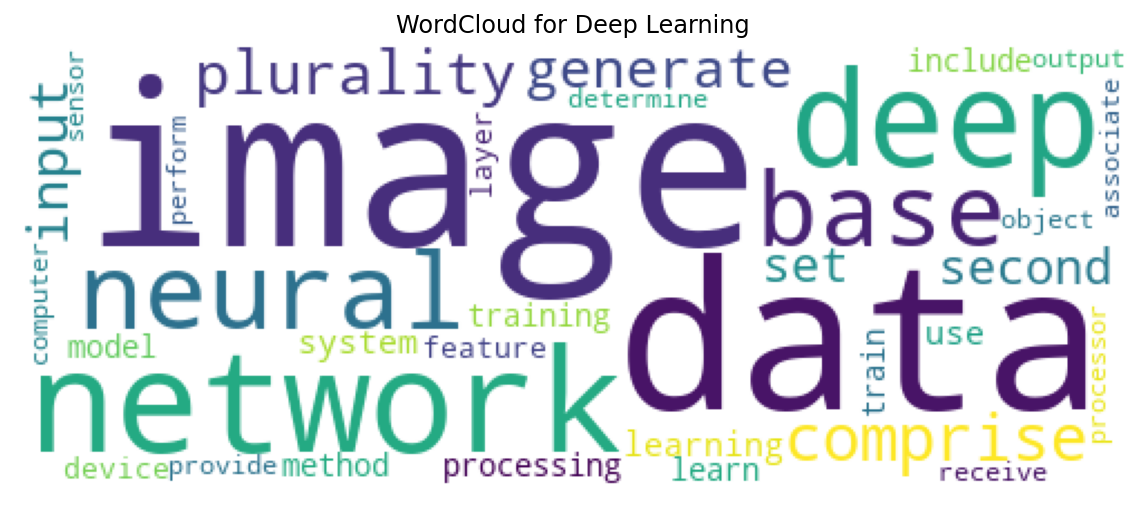

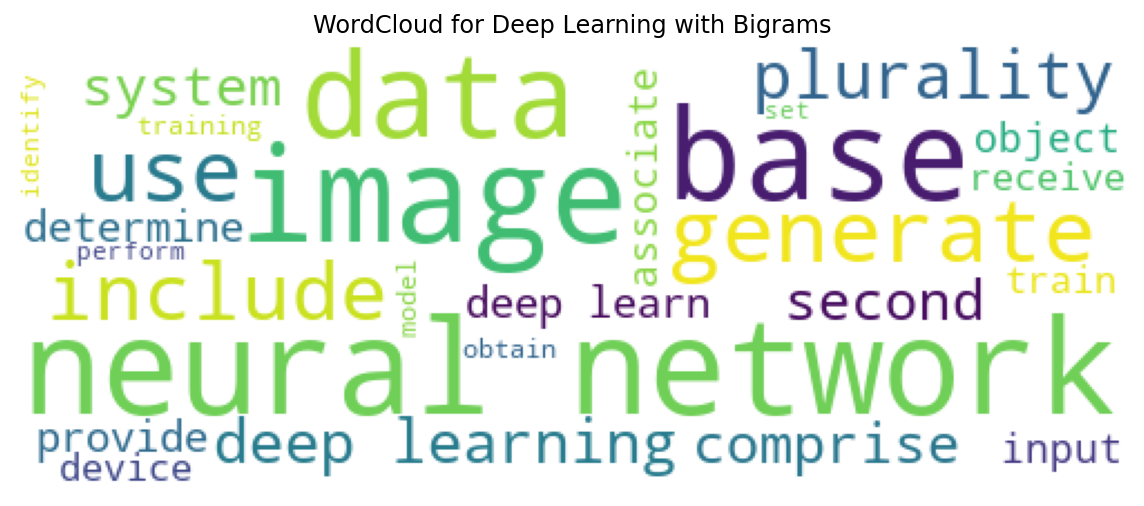

In [38]:
plot_wordCloud(paper_target_words[0], "WordCloud for Deep Learning") ## deep learning

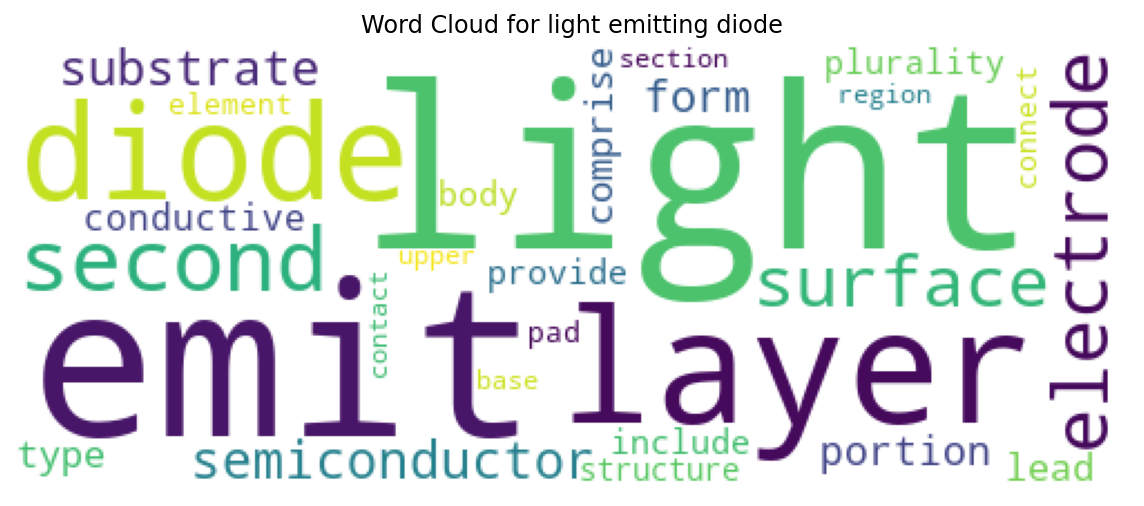

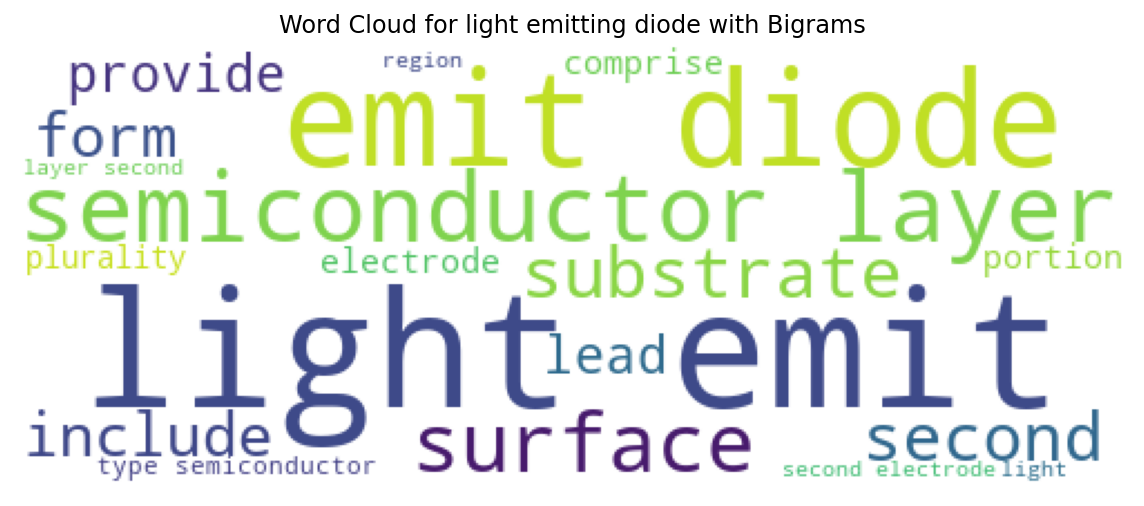

In [39]:
plot_wordCloud(paper_target_words[1], "Word Cloud for light emitting diode") ## light emitting diode

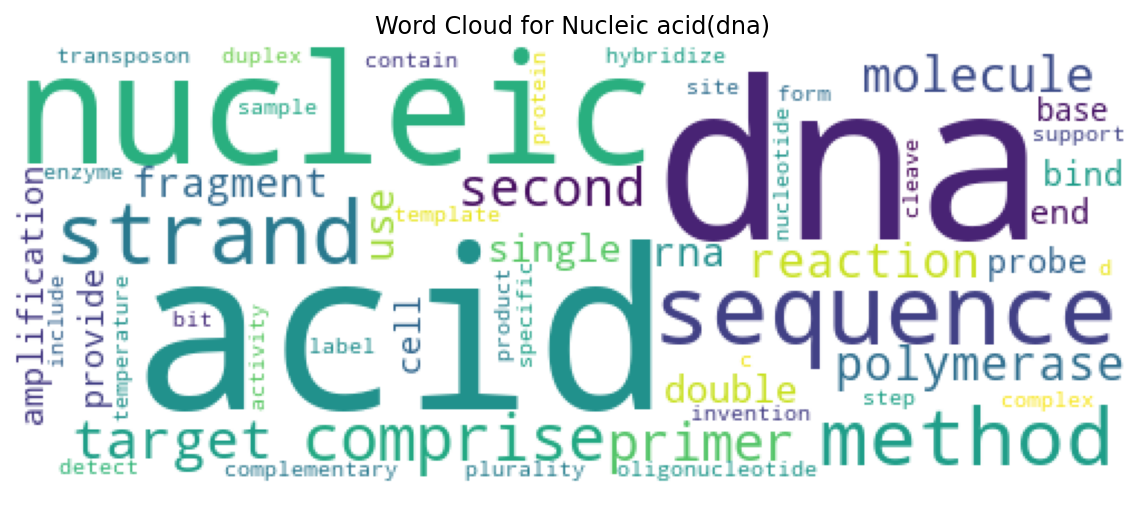

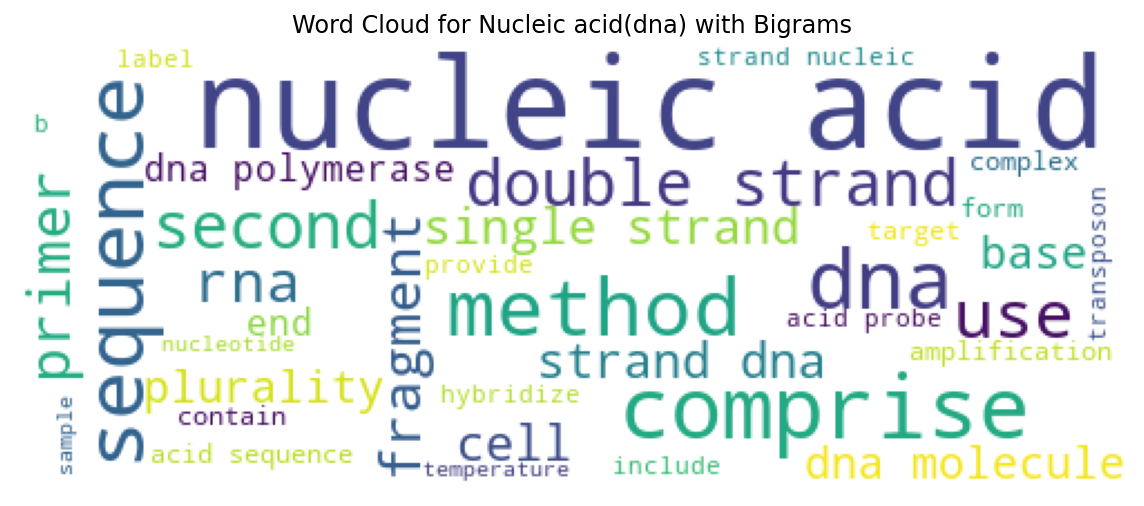

In [40]:
plot_wordCloud(paper_target_words[2], "Word Cloud for Nucleic acid(dna)") ## nucleic acid(dna)

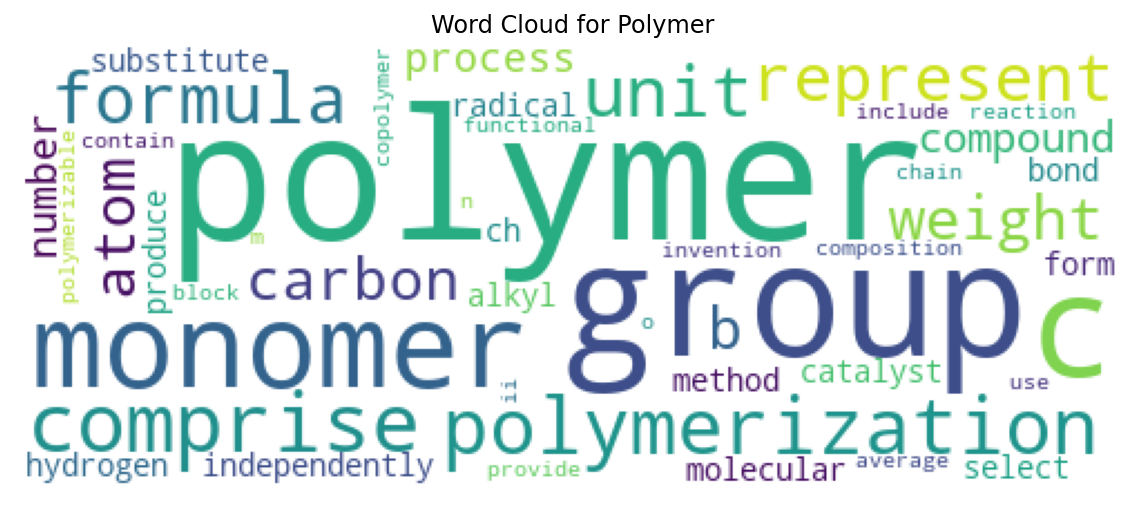

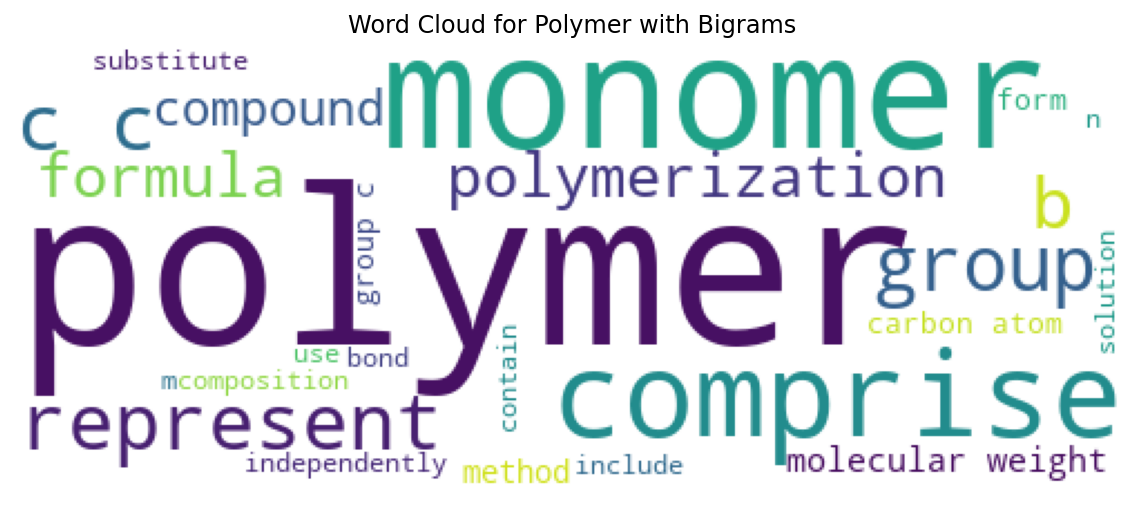

In [41]:
plot_wordCloud(paper_target_words[3], "Word Cloud for Polymer") ## polymer

Alright we can observer that wordcloud has picked so many domain specfic words, that probably the model should do great for classfying the targets.

We will we using probabilistic model for learning, its best suited for such text classification task

In [42]:
def apply_nb(features, target, report = True):
    X_train, X_test, Y_train, Y_test = train_test_split(features, target, test_size = 0.2)
    
    
    vectorizer = TfidfVectorizer()
    
    #generating embeddings for train and test features
    X_train = vectorizer.fit_transform(X_train)
    X_test = vectorizer.transform(X_test)
    
    model = MultinomialNB()
    model.fit(X_train, Y_train)
    
    if report:
        generate_reports(model,X_train, X_test, Y_train, Y_test)
    
    return model

def generate_reports(model,X_train, X_test, Y_train, Y_test):
    P_train = model.predict(X_train)
    P_test = model.predict(X_test)
    print(".................Report for Training set....................")
    print("Confusion Matrix")
    print(confusion_matrix(Y_train, P_train),"\n")
    print(Y_train.shape)
    print("Accuracy: ", accuracy_score(Y_train, P_train))
    
    
    print("Classification Report")
    print(classification_report(Y_train, P_train),"\n")
    
    
    print(".................Report for Testing set....................")
    print("Confusion Matrix")
    print(confusion_matrix(Y_test, P_test), "\n")
    print("Accuracy: ", accuracy_score(Y_test, P_test))

    
    print("Classification Report")
    print(classification_report(Y_test, P_test),"\n")

In [45]:
model1 = apply_nb(df['Paper_Text'], df['Target'])

.................Report for Training set....................
Confusion Matrix
[[44  0  0  0]
 [ 0 36  0  0]
 [ 0  0 40  0]
 [ 0  0  0 40]] 

(160,)
Accuracy:  1.0
Classification Report
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        44
           1       1.00      1.00      1.00        36
           2       1.00      1.00      1.00        40
           3       1.00      1.00      1.00        40

    accuracy                           1.00       160
   macro avg       1.00      1.00      1.00       160
weighted avg       1.00      1.00      1.00       160
 

.................Report for Testing set....................
Confusion Matrix
[[ 6  0  0  0]
 [ 0 14  0  0]
 [ 0  0 10  0]
 [ 0  0  0 10]] 

Accuracy:  1.0
Classification Report
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         6
           1       1.00      1.00      1.00        14
           2       1.00      1.00     

**Let's summarize our results**
1. We start with cleaning and then the only thing remained were words which have occured atleast 5 times or more.
2. The embedding we use was tf-idf, this gives importance to words which appear many times but only in few documents, so our cleaned version of data supports this wonderfully.
3. As far as results of the model, it has fitted 100 % to our data, so that's decent.
4. The WordCloud does gives us lot's of information as how the pattern specific to domain helps drastically to classify (it gives us all the insights why the model works well)
5. As majority of words lets say for Polymer papers, (polymer,monomer,carbon,atom,compound) appears only in the set of Polymer papers with a high frequency count, that's exactly how you score well with tf-idf.
